# 1. Tiền xử lý dữ liệu

## 1.1 Chuẩn hóa dữ liệu

In [85]:
import os, sys, json, re, unicodedata, html, string, random
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

In [86]:
PROJECT_ROOT = Path(r"D:\Projects\Tiny Transforner for Machine Translation")
RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_DIR = PROJECT_ROOT / "models"
REPORTS_DIR = PROJECT_ROOT / "reports"
for d in (RAW_DIR, PROCESSED_DIR, MODEL_DIR, REPORTS_DIR):
    d.mkdir(parents=True, exist_ok=True)

RAW_EN = RAW_DIR / "train_en.txt"
RAW_VI = RAW_DIR / "train_vi.txt"
print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_EN:", RAW_EN)
print("RAW_VI:", RAW_VI)

PROJECT_ROOT: D:\Projects\Tiny Transforner for Machine Translation
RAW_EN: D:\Projects\Tiny Transforner for Machine Translation\data\raw\train_en.txt
RAW_VI: D:\Projects\Tiny Transforner for Machine Translation\data\raw\train_vi.txt


In [87]:
#Kiểm tra dữ liệu
def read_lines_utf8(path: Path):
    text = path.read_text(encoding="utf-8")
    return text.splitlines()

en_raw = read_lines_utf8(RAW_EN)
vi_raw = read_lines_utf8(RAW_VI)

In [88]:
assert len(en_raw) == len(vi_raw), f"Length mismatch EN={len(en_raw)} vs VI={len(vi_raw)}"
assert all(line is not None for line in en_raw) and all(line is not None for line in vi_raw)

print(f"Num pairs: {len(en_raw)}")
print("Preview (first 5 lines):")
for i in range(min(5, len(en_raw))):
    print(f"[{i}] EN: {en_raw[i]}")
    print(f"    VI: {vi_raw[i]}")

Num pairs: 41
Preview (first 5 lines):
[0] EN: Banh mi, pho, iced coffee and Hoi An cao lau noodles have earned high marks from international travel magazines in 2022, reaffirming Vietnam’s growing reputation as a global culinary attraction. 
    VI: Bánh mì, phở, cà phê đá và cao lầu Hội An đã giành được điểm cao từ các tạp chí du lịch quốc tế vào năm 2022, tái khẳng định danh tiếng ngày càng tăng của Việt Nam như một điểm thu hút ẩm thực toàn cầu. 
[1] EN: In January, CNN included pho bo (Vietnamese beef noodle soup) in its list of the 20 best soups in the world, along with China’s Lanzhou noodle soup, and Thailand’s tom yum goong.
    VI: Vào tháng 1, CNN đã đưa phở bò vào danh sách 20 món canh ngon nhất thế giới, cùng với phở Lan Châu của Trung Quốc và tom yum goong của Thái Lan.
[2] EN: Till now, pho bo remains the most beloved version of the dish in Vietnam and has become the most popular breakfast in the country, with options that include the original raw beef, a mix of raw and 

In [89]:
#Làm sạch dữ liệu

#Regex tiền biên dịch
RE_CONTROL      = re.compile(r"[\u0000-\u001F\u007F]", flags=re.UNICODE)
RE_ZW           = re.compile(r"[\u200B-\u200F\u202A-\u202E\u2060-\u206F\uFEFF]")
RE_HTML_TAG     = re.compile(r"<[^>]+>")
RE_MULTISPACE   = re.compile(r"\s+")
RE_SP_BEFORE_P  = re.compile(r"\s+([,.:;!?])")
RE_SPACE_POPEN  = re.compile(r"\(\s+")
RE_SPACE_PCLOSE = re.compile(r"\s+\)")
RE_MULTI_DOTS   = re.compile(r"\.{3,}")           # ellipsis
RE_MULTI_DASH   = re.compile(r"[–—−]+")           # dash variants
RE_QUOTE_CHARS  = re.compile(r"[“”«»„‟‚‛]")        # thành "

In [90]:
#Chuẩn hóa về Unicode NFC
def normarlize_unicode_nfc(s: str) -> str:
    return unicodedata.normalize("NFC", s)
#Loại bỏ ký tự điều khiển và ký tự không hiển thị
def strip_controls_zero_width(s: str) -> str:
    s = RE_CONTROL.sub(" ", s)
    s = RE_ZW.sub("", s)
    return s
#Loại bỏ thẻ HTML
def dehtml(s: str) -> str:
    s = html.unescape(s)
    s = RE_HTML_TAG.sub(" ", s)
    return s
#Hàm chuẩn hóa dấu câu
def normalize_punct(s: str) -> str:
    s = RE_QUOTE_CHARS.sub('"', s)        # fancy quotes -> "
    s = RE_MULTI_DASH.sub("-", s)         # normalize dash -> hyphen
    s = RE_MULTI_DOTS.sub("...", s)       # normalize ellipsis
    return s
#Hàm chuẩn hóa khoảng trắng
def normalize_spacing(s: str) -> str:
    s = RE_SP_BEFORE_P.sub(r"\1", s)      # bỏ space trước dấu câu
    s = RE_SPACE_POPEN.sub("(", s)        # bỏ space sau "("
    s = RE_SPACE_PCLOSE.sub(")", s)       # bỏ space trước ")"
    s = RE_MULTISPACE.sub(" ", s)         # gộp space/tabs/newlines
    return s.strip()
#Hàm tiền xử lý tổng hợp
def clean_text(s: str, lang: str) -> str:
    s = normarlize_unicode_nfc(s)
    s = strip_controls_zero_width(s)
    s = dehtml(s)
    s = normalize_punct(s)
    if lang == "en":
        s = s.lower()
    s = normalize_spacing(s)
    return s


In [91]:
#Áp dụng để làm sạch dữ liệu
en_clean = [clean_text(x, "en") for x in en_raw]
vi_clean = [clean_text(x, "vi") for x in vi_raw]

df = pd.DataFrame({
    "idx": np.arange(len(en_raw)),
    "EN_raw": en_raw,
    "VI_raw": vi_raw,
    "EN": en_clean,
    "VI": vi_clean,
})


print(f"Total rows after cleaning (no filtering yet): {len(df)}")
df.head(10)

Total rows after cleaning (no filtering yet): 41


,idx,EN_raw,VI_raw,EN,VI
0,0,"Banh mi, pho, iced coffee and Hoi An cao lau n...","Bánh mì, phở, cà phê đá và cao lầu Hội An đã g...","banh mi, pho, iced coffee and hoi an cao lau n...","Bánh mì, phở, cà phê đá và cao lầu Hội An đã g..."
1,1,"In January, CNN included pho bo (Vietnamese be...","Vào tháng 1, CNN đã đưa phở bò vào danh sách 2...","in january, cnn included pho bo (vietnamese be...","Vào tháng 1, CNN đã đưa phở bò vào danh sách 2..."
2,2,"Till now, pho bo remains the most beloved vers...","Cho đến nay, phở bò vẫn là phiên bản được yêu ...","till now, pho bo remains the most beloved vers...","Cho đến nay, phở bò vẫn là phiên bản được yêu ..."
3,3,A bowl of pho bo in Ho Chi Minh City and Hanoi...,Một tô phở bò ở Thành phố Hồ Chí Minh và Hà Nộ...,a bowl of pho bo in ho chi minh city and hanoi...,Một tô phở bò ở Thành phố Hồ Chí Minh và Hà Nộ...
4,4,"In May, CNN included Vietnam’s popular banh mi...","Vào tháng 5, CNN đã đưa món bánh mì nổi tiếng ...","in may, cnn included vietnam’s popular banh mi...","Vào tháng 5, CNN đã đưa món bánh mì nổi tiếng ..."
5,5,Considered the most popular street food in Vie...,Được coi là món ăn đường phố phổ biến nhất ở V...,considered the most popular street food in vie...,Được coi là món ăn đường phố phổ biến nhất ở V...
6,6,A banh mi also often includes toppings such as...,Một chiếc bánh mì cũng thường bao gồm các loại...,a banh mi also often includes toppings such as...,Một chiếc bánh mì cũng thường bao gồm các loại...
7,7,A loaf with all the trimmings costs from VND15...,Một ổ bánh mì với đầy đủ các lát cắt đó có giá...,a loaf with all the trimmings costs from vnd15...,Một ổ bánh mì với đầy đủ các lát cắt đó có giá...
8,8,American tourist Rita Joe Graybill described V...,Du khách người Mỹ Rita Joe Graybill mô tả bánh...,american tourist rita joe graybill described v...,Du khách người Mỹ Rita Joe Graybill mô tả bánh...
9,9,"Also in May, CNN named banh cam, Vietnamese de...","Cũng trong tháng 5, CNN đã vinh danh bánh cam,...","also in may, cnn named banh cam, vietnamese de...","Cũng trong tháng 5, CNN đã vinh danh bánh cam,..."


In [92]:
#Lọc cặp câu theo độ dài và tỉ lệ độ dài
MIN_TOK = 1
MAX_TOK = 100
RATIO_MIN, RATIO_MAX = 0.3, 3.0  # len(VI)/len(EN)

def num_tokens(s: str) -> int:
    return len(s.split())

df["en_tok"] = df["EN"].apply(num_tokens)
df["vi_tok"] = df["VI"].apply(num_tokens)
df["len_ratio"] = df.apply(lambda r: (r["vi_tok"] / max(1, r["en_tok"])) if r["en_tok"] > 0 else np.inf, axis=1)

def row_reason(r):
    reasons = []
    if r["EN"] == "" or r["VI"] == "":
        reasons.append("empty_after_clean")
    if not (MIN_TOK <= r["en_tok"] <= MAX_TOK) or not (MIN_TOK <= r["vi_tok"] <= MAX_TOK):
        reasons.append("len_out_of_range")
    if not (RATIO_MIN <= r["len_ratio"] <= RATIO_MAX):
        reasons.append("ratio_out_of_range")
    return ",".join(reasons)

df["remove_reason"] = df.apply(row_reason, axis=1)
df["keep"] = df["remove_reason"].eq("")

removed = df.loc[~df["keep"]]
kept    = df.loc[df["keep"]]

print({
    "num_total": len(df),
    "num_kept": len(kept),
    "num_removed": len(removed),
    "removed_empty": int(removed["remove_reason"].str.contains("empty_after_clean").sum()),
    "removed_len":   int(removed["remove_reason"].str.contains("len_out_of_range").sum()),
    "removed_ratio": int(removed["remove_reason"].str.contains("ratio_out_of_range").sum()),
})


{'num_total': 41, 'num_kept': 41, 'num_removed': 0, 'removed_empty': 0, 'removed_len': 0, 'removed_ratio': 0}


In [93]:
#Khử trùng lặp
kept_df = kept.copy()

kept_df["pair_dup"] = kept_df.duplicated(subset=["EN","VI"], keep="first")
kept_df["en_dup"]   = kept_df.duplicated(subset=["EN"], keep="first")

dedup_df = kept_df[(~kept_df["pair_dup"]) & (~kept_df["en_dup"])].copy()
dedup_df = dedup_df.sort_values("idx").reset_index(drop=True)

print({
    "after_filter": len(kept_df),
    "exact_pair_dups": int(kept_df["pair_dup"].sum()),
    "en_dups_removed": int(kept_df["en_dup"].sum()),
    "after_dedup": len(dedup_df),
})

{'after_filter': 41, 'exact_pair_dups': 0, 'en_dups_removed': 0, 'after_dedup': 41}


In [94]:
# Xuất các file dữ liệu đã làm sạch

clean_en_path   = PROCESSED_DIR / "clean_train_en.txt"
clean_vi_path   = PROCESSED_DIR / "clean_train_vi.txt"
pairs_tsv_path  = PROCESSED_DIR / "clean_pairs_train.txt"
report_json_path= PROCESSED_DIR / "clean_report.json"

clean_en_path.write_text("\n".join(dedup_df["EN"].tolist()), encoding="utf-8")
clean_vi_path.write_text("\n".join(dedup_df["VI"].tolist()), encoding="utf-8")
pairs_tsv_path.write_text(
    "EN\tVI\n" + "\n".join(f"{e}\t{v}" for e,v in zip(dedup_df["EN"], dedup_df["VI"])),
    encoding="utf-8",
)

report = {
    "project_root": str(PROJECT_ROOT),
    "input_files": {"raw_en": str(RAW_EN), "raw_vi": str(RAW_VI)},
    "output_files": {
        "clean_en": str(clean_en_path),
        "clean_vi": str(clean_vi_path),
        "pairs_tsv": str(pairs_tsv_path)
    },
    "filters": {
        "min_tokens": MIN_TOK,
        "max_tokens": MAX_TOK,
        "len_ratio_min": RATIO_MIN,
        "len_ratio_max": RATIO_MAX,
        "lowercase_en": True,
        "unicode_norm": "NFC",
        "strip_controls": True,
        "strip_zero_width": True,
        "html_unescape": True,
        "normalize_punct": True
    },
    "stats": {
        "num_total": int(len(df)),
        "num_kept_after_filters": int(len(kept_df)),
        "num_after_dedup": int(len(dedup_df)),
        "num_removed": int(len(df) - len(kept_df)),
    },
}
report_json_path.write_text(json.dumps(report, ensure_ascii=False, indent=2), encoding="utf-8")

print("Saved:")
print(" -", clean_en_path)
print(" -", clean_vi_path)
print(" -", pairs_tsv_path)
print(" -", report_json_path)


Saved:
 - D:\Projects\Tiny Transforner for Machine Translation\data\processed\clean_train_en.txt
 - D:\Projects\Tiny Transforner for Machine Translation\data\processed\clean_train_vi.txt
 - D:\Projects\Tiny Transforner for Machine Translation\data\processed\clean_pairs_train.txt
 - D:\Projects\Tiny Transforner for Machine Translation\data\processed\clean_report.json


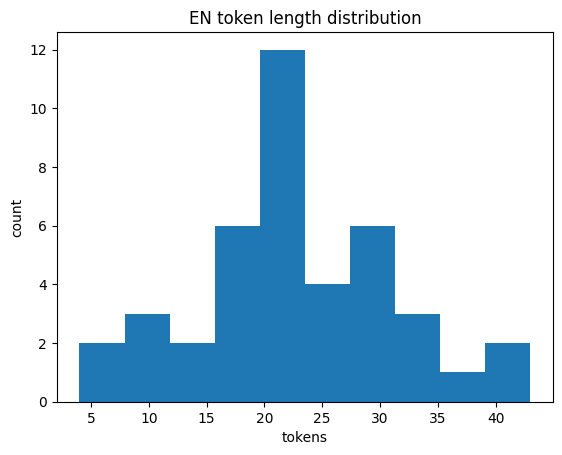

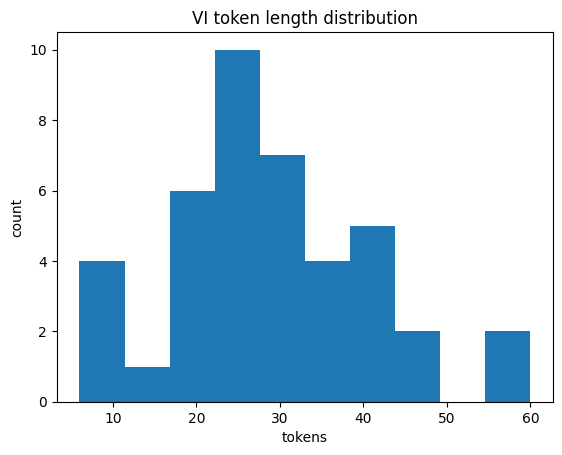

In [95]:
#Trực quan hóa phân phối độ dài câu
en_lens = dedup_df["EN"].str.split().apply(len).values
vi_lens = dedup_df["VI"].str.split().apply(len).values

plt.figure()
plt.hist(en_lens, bins=10)
plt.title("EN token length distribution")
plt.xlabel("tokens"); plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(vi_lens, bins=10)
plt.title("VI token length distribution")
plt.xlabel("tokens"); plt.ylabel("count")
plt.show()


In [96]:
#Làm tương tự với dữ liệu test: test_en.txt và test_vi.txt
TEST_RAW_EN = RAW_DIR / "test_en.txt"
TEST_RAW_VI = RAW_DIR / "test_vi.txt"
TEST_EN = PROCESSED_DIR / "clean_test_en.txt"
TEST_VI = PROCESSED_DIR / "clean_test_vi.txt"
test_pairs_tsv_path  = PROCESSED_DIR / "clean_pairs_test.txt"
test_en_raw = read_lines_utf8(TEST_RAW_EN)
test_vi_raw = read_lines_utf8(TEST_RAW_VI)  
test_en_clean = [clean_text(x, "en") for x in test_en_raw]
test_vi_clean = [clean_text(x, "vi") for x in test_vi_raw]
TEST_EN.write_text("\n".join(test_en_clean), encoding="utf-8")
TEST_VI.write_text("\n".join(test_vi_clean), encoding="utf-8")  
test_pairs_tsv_path.write_text(
    "EN\tVI\n" + "\n".join(f"{e}\t{v}" for e,v in zip(test_en_clean, test_vi_clean)),
    encoding="utf-8",
)
print("Saved cleaned test files:")
print(" -", TEST_EN)    
print(" -", TEST_VI)


Saved cleaned test files:
 - D:\Projects\Tiny Transforner for Machine Translation\data\processed\clean_test_en.txt
 - D:\Projects\Tiny Transforner for Machine Translation\data\processed\clean_test_vi.txt
